## Competition description

Is there a cat in your dat?

A common task in machine learning pipelines is encoding categorical variables for a given algorithm in a format that allows as much useful signal as possible to be captured.

Because this is such a common task and important skill to master, we've put together a dataset that contains only categorical features, and includes:

- binary feautures

- low and high - cardinality nominal features

- low and high - cardinality ordinal features

- (potentially) cyclical features

This playground competition will give you the opportunity to try different encoding schemes for different algorithms to compare how they perform. We encourage you to share what you find with the community.

If you're not sure how to get started, you can check out the Categorical Variables section of Kaggle's Intermediate Machine Learning course.

## Objective

I want to do complete exploration to understand the data and after it I will build a Machine Learning Model.

## Questions

Before I start handlinng the data, I am thinking about what I want to find here, like:

- What't the target distribution and what data type it is?

- What is the type of features we have and the name? These names can tell us anything?

- What's the most common values in all category's we have?

- How mamy binary features we have?

- How many missing values?

- Which type of transformations we need to apply?

## Importing Libray's

In [2]:
# !pip install hyperopt 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 17.2 MB/s eta 0:00:00
  Using cached future-0.18.3.tar.gz (840 kB)
  Preparing metadata (setup.py) ... done
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=0a680082538b9ea5c5d54da1a5b19c2ebbcea4a18c844ac4be4bec2e6a8bba1d
  Stored in directory: /home/tw/.cache/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

# Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

import gc
import warnings
warnings.filterwarnings("ignore")

## Some utilities functions

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
p = '../source/dataset/cat-in-the-dat'
df_train = pd.read_csv(f'{p}/train.csv')
df_test = pd.read_csv(f'{p}/test.csv')
submission = pd.read_csv(f'{p}/sample_submission.csv', index_col = 'id')

#### Knowing our data

In [8]:
summary = resumetable(df_train)
summary

Dataset Shape: (300000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,300000,0,1,2,18.19
1,bin_0,int64,0,2,0,0,0,0.55
2,bin_1,int64,0,2,0,1,0,0.82
3,bin_2,int64,0,2,0,0,0,0.96
4,bin_3,object,0,2,T,T,F,1.00
5,bin_4,object,0,2,Y,Y,Y,0.94
6,nom_0,object,0,3,Green,Green,Blue,1.55
7,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid,2.45
8,nom_2,object,0,6,Snake,Hamster,Lion,2.44
9,nom_3,object,0,6,Finland,Russia,Russia,2.45


Cool!! As we can note we don't have missing values and it's nice to us.<br>
I will start exploring the Target and trying to find some patterns that could explain it.

## Target Feature

Let's see the distribution and if we can identify what is the nature of this feature.

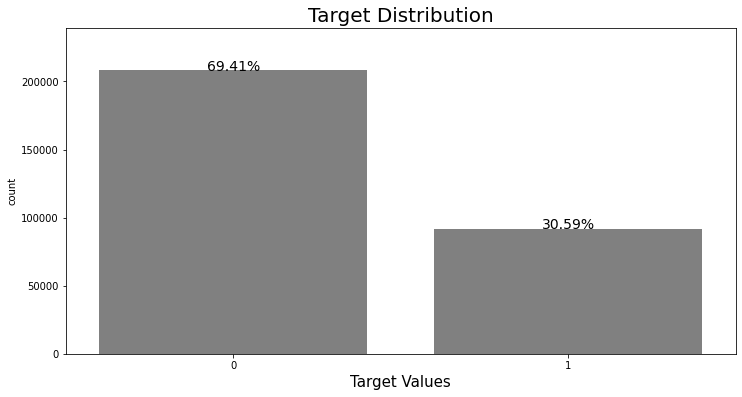

In [9]:
total = len(df_train)
plt.figure(figsize = (12, 6))

g = sns.countplot(x = 'target', data = df_train, color = 'grey') # plot을 객체로 받고
g.set_title("Target Distribution", fontsize = 20) #set_title
g.set_xlabel("Target Values", fontsize = 15) # set_xlabel
sizes = [] # Get highest values in y
for p in g.patches: #객체.patches
    height = p.get_height() # 높이뽑고
    sizes.append(height)
    g.text(p.get_x() + p.get_width()/2., # x위치
           height , '{:1.2f}%'.format(height/total * 100),# y위치
           ha = 'center', fontsize = 14)
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

Cool! We can see that our target is a binary feature and as it is 0 or 1 we can't know what is about.<br>
Another interesting thing to note is that isn't so imbalanced:

- Category 0 with 79.4%

- Category 1 with 30.6%

Now, as we have much of them, let's explore the patterns of other binary features.

## Binary Features

In [10]:
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

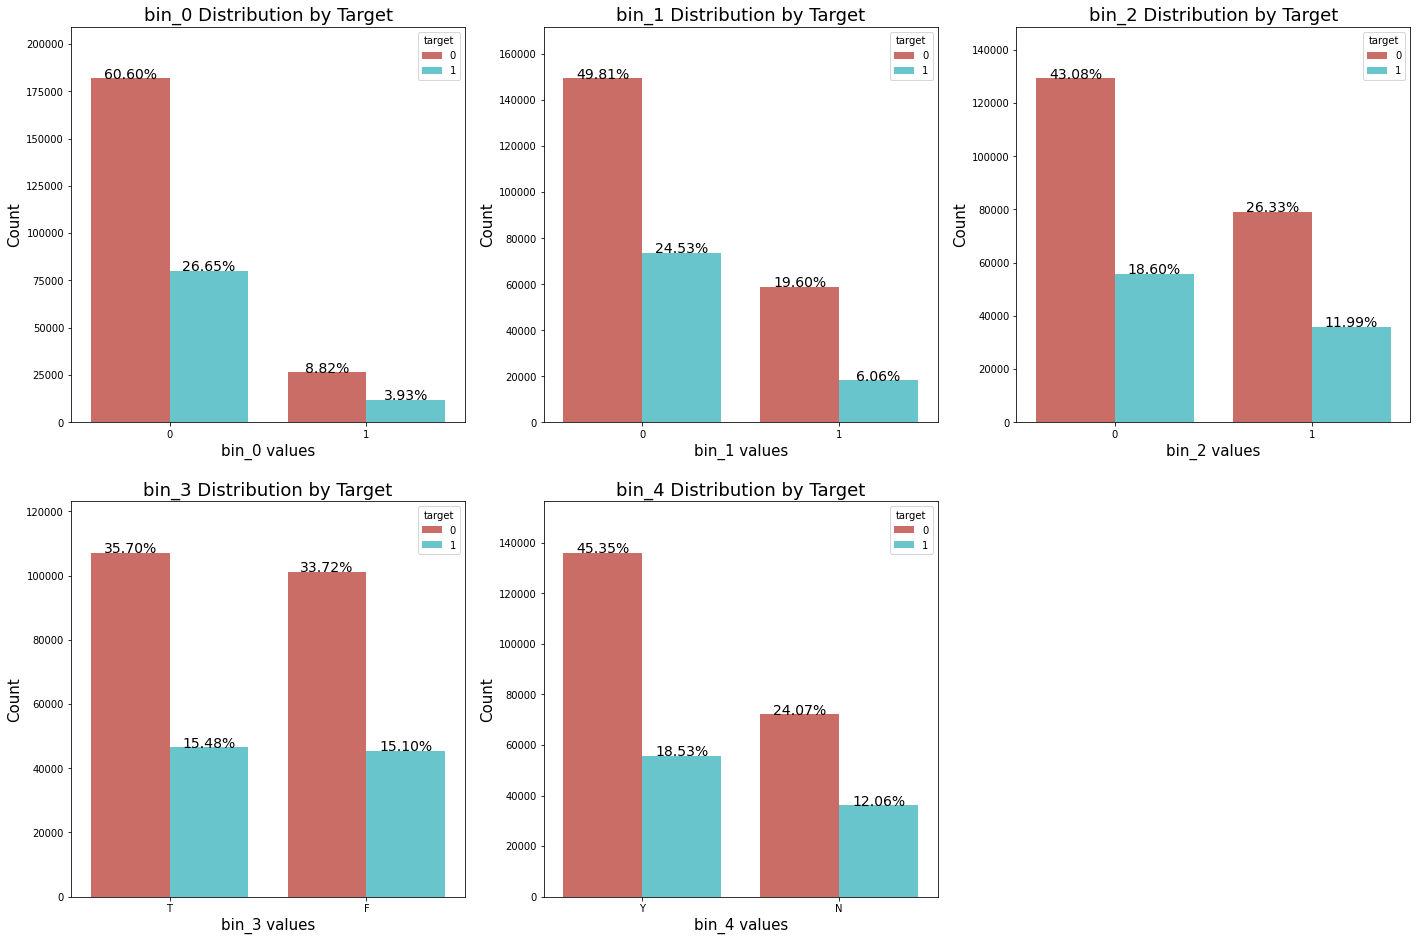

In [11]:
# Looking the V's features
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(2, 3) # The grid of chart
plt.figure(figsize = (24, 16)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(df_train[bin_cols]):
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x = col, data = df_train ,hue = 'target', palette = 'hls')
    ax.set_ylabel('Count', fontsize = 15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize = 18) # title label
    ax.set_xlabel(f'{col} values', fontsize = 15) # x axis label
    sizes = []
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total * 100),
            ha = 'center', fontsize = 14)
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

We can't see any clear pattern to positive values in target.

- It's interesting to see that in bin_3 the ratio of target true have the same size in both values.(~15%)

- In the other binary features the pattern is very similar.

## Working on binary Features

- To work in machine learning models, we need numerical features.

- As we can note, 3 of binary feaures are already integer features (0 or 1)

- We will need to work on the features that isn't in numerical representation.

I'm assuming that:

- T is True and F is False

- Y is Yes and N is No

In [12]:
# dictionary to map the feature
bin_dict = {'T' : 1, 'F' : 0, 'Y' : 1, 'N' : 0}

# Mapping the category values in our dict
df_train['bin_3'] = df_train['bin_3'].map(bin_dict)
df_train['bin_4'] = df_train['bin_4'].map(bin_dict)
df_test['bin_3'] = df_test['bin_3'].map(bin_dict)
df_test['bin_4'] = df_test['bin_4'].map(bin_dict)

### Checking the results

In [13]:
df_train[['bin_3', 'bin_4']].head()

,bin_3,bin_4
0,1,1
1,1,1
2,0,1
3,0,1
4,0,0


Cool! Now, it's ok to model this feature into a machine learning algorithm.<br>
Let's work in the other features.

## Nominal Features (with more than 2 and less than 15 values)

Let's see the distribution of the feature and target Ratio for each value in nominal features

In [14]:
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

In [15]:
def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(df_train[cols]): 
        tmp = pd.crosstab(df_train[col], df_train['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df_train, order=list(tmp[col].values) , color='green') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()
      

TypeError: pointplot() got an unexpected keyword argument 'legend'

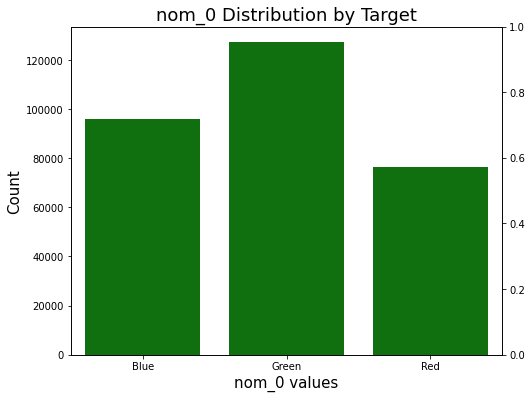

In [16]:
ploting_cat_fet(df_train, nom_cols, vis_row = 5, vis_col = 2)

Nice! We can see clear different patterns between the nominal category values.

Some summary of these features:<br>

- NOM_0 - Red (~35%) value have the highest % of positive values in the target.

- NOM_1 - Triangle (~36%) value have the highest % of positive values in the target.

- NOM_2 - Hamster(~36%) value have the highest % of positive values in the target.

- NOM_3 - India(~36%) value have the highest % of positive values in the target.

- NOM_4 - Theremin(~36%) value have the highest % of positive values in the target.

Do you noted something?<br>
All the values with highest % of True values on target, are the category's with lowest frequency on the nominal category's. We need to handle with all these features.<br>
As it is nominal and don't have so many values by category's we can transform it in dummy features.

## Nominal Features Transformation

In [17]:
df_test['target'] = 'test'
df = pd.concat([df_train, df_test], axis = 0, sort = False)

In [18]:
print(f'Shape before dummy transformation: {df.shape}')
df = pd.get_dummies(df, columns = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],
                   prefix = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], drop_first = True)
print(f'Shape after dummy transformation: {df.shape}')

Shape before dummy transformation: (500000, 25)
Shape after dummy transformation: (500000, 40)


In [19]:
df_train, df_test = df[df['target'] != 'test'], df[df['target'] == 'test'].drop('target', axis=1)
del df

In [20]:
df_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0,0,0,1,1,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,...,0,1,0,0,1,0,0,0,0,0
1,1,0,1,0,1,1,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,...,0,0,0,0,0,0,1,0,1,0
2,2,0,0,0,0,1,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,...,1,0,0,0,0,0,1,0,0,1
3,3,0,1,0,0,1,f12246592,50d7ad46a,ec69236eb,4ade6ab69,...,0,1,0,0,0,0,0,1,0,0
4,4,0,0,0,0,0,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,...,1,0,0,0,0,0,0,1,0,0


Nice, we can see that it worked.<br>
Now, let's see the remaining columns with few category values.

## Ordinal Features (with more than 2 and less than 15 values)

In [21]:
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3']

#### Ploting ordinal features

TypeError: pointplot() got an unexpected keyword argument 'legend'

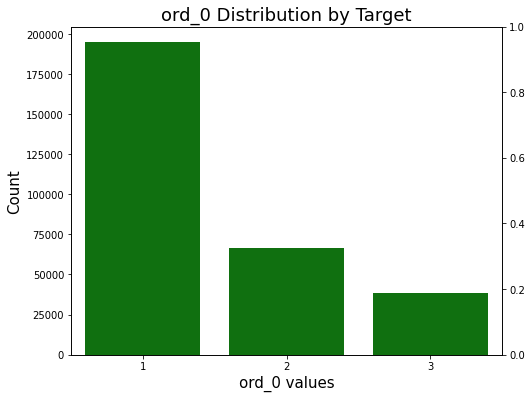

In [22]:
ploting_cat_fet(df_train, ord_cols, vis_row = 5, vis_col = 2)

Cool! In Ordinal features, the rule of nominal isn't real.<br>
We can see that only on ord_0 the highest ratio in target in the less common category.

As the "ord_4" and "ord_5" have highest cardinality I will plot it separated.

### Ord_4 and ord_5

In [23]:
df_train['ord_5_ot'] = 'Others'
df_train.loc[df_train['ord_5'].isin(df_train['ord_5'].value_counts()[:25].sort_index().index), 'ord_5_ot'] = df_train['ord_5'] # 상위 25개만 저장

TypeError: pointplot() got an unexpected keyword argument 'legend'

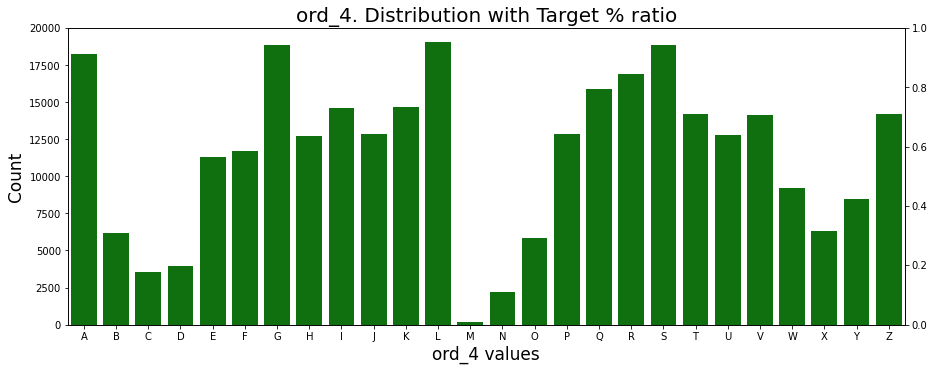

In [24]:
tmp = pd.crosstab(df_train['ord_4'], df_train['target'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0 : 'No', 1 : 'Yes'}, inplace = True)
plt.figure(figsize = (15,12))

plt.subplot(211)
ax = sns.countplot(x = 'ord_4', data = df_train, order = list(tmp['ord_4'].values), color = 'green')
ax.set_ylabel('Count', fontsize = 17) # y axis label
ax.set_title('ord_4. Distribution with Target % ratio', fontsize = 20) # title label
ax.set_xlabel('ord_4 values', fontsize = 17) # x axis label
# twinX - to build a second yaxis
gt = ax.twinx()
gt = sns.pointplot(x = 'ord_4', y = 'Yes', data = tmp,
                  order = list(tmp['ord_4'].values),
                  color = 'black', legend = False)
gt.set_ylim(tmp['Yes'].min() - 5, tmp['Yes'].max() * 1.1)
gt.set_ylabel("Target %True(1)", fontsize = 16)

tmp = pd.crosstab(df_train['ord_5_ot'], df_train['target'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0 : 'No', 1 : 'Yes'}, inplace = True)

plt.subplot(212)
ax1 = sns.countplot(x = 'ord_5_ot', data = df_train,
                  order = list(df_train['ord_5_ot'].value_counts().sort_index().index),
                  color = 'green')
ax1.set_ylabel('Count', fontsize = 17) # y axis label
ax1.set_title('TOP 25 ord_5 and "others" Distribution with Target %ratio', fontsize = 20) # title label
ax1.set_xlabel('ord_5 values', fontsize = 17) # x axis label
# twinX - to build a second yaxis
gt = ax1.twinx()
gt = sns.pointplot(x = 'ord_5_ot', y = 'Yes', data = tmp,
                  order = list(df_train['ord_5_ot'].value_counts().sort_index().index),
                  color = 'black', legend = False)
gt.set_ylim(tmp['Yes'].min() - 5, tmp['Yes'].max() * 1.1)
gt.set_ylabel("Target %True(1)", fontsize = 16)

plt.subplots_adjust(hspace = 0.4, wspace = .3)

plt.show()

Cool!

- In ord_4, as it is a ordinal feature, we can see a clearly linear relationship. As it is the alphabet order, it will be easy to encde.

- In ord_5 we have many category's, the top category is : <br>
    1- "od" with 5019 entries,<br>
    2 - "f0" with 3435 entries,<br>
    3 - "Zq" with 2926<br>
 
 
I will explore further the ord_5 Feature. I will explore the distribution of the values and how it is.

In [25]:
ord_5_count = df_train['ord_5'].value_counts().reset_index()['ord_5'].values

### Distribution of ord_5 features

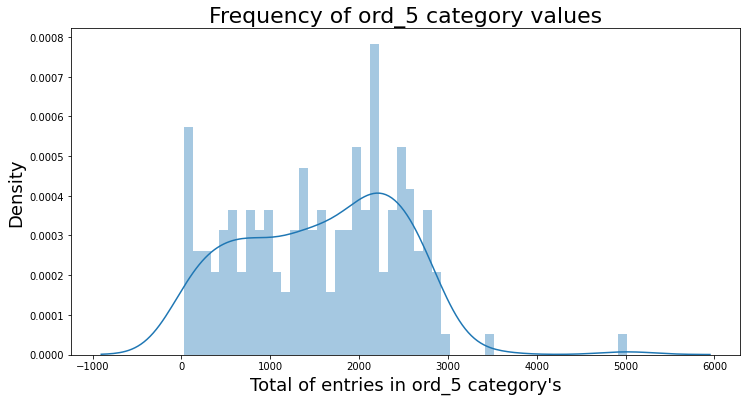

In [26]:
plt.figure(figsize = (12, 6))

g = sns.distplot(ord_5_count, bins = 50)
g.set_title("Frequency of ord_5 category values", fontsize = 22)
g.set_xlabel("Total of entries in ord_5 category's", fontsize = 18)
g.set_ylabel("Density", fontsize = 18)

plt.show()

Cool!<br>
We can see that many values in ord_5 have ~2100 entries.<br>
Also, the data has many category's with ~100 entries.

### Ordinal Features Transformation

- Only ord_0 is numerical values.

- We need to transform ord_1, ord_2 and ord_3 to set it in the correctly order to feed the machine learning model.

In [27]:
# Importing categorical options of pandas
from pandas.api.types import CategoricalDtype

# seting the orders of our ordinal features
ord_1 = CategoricalDtype(categories = ['Novice', 'Contributor', 'Expert',
                                      'Master', 'Grandmaster'], ordered = True)
ord_2 = CategoricalDtype(categories = ['Freezing', 'Cold', 'Warm', 'Hot',
                                        'Boiling Hot', 'Lava Hot'], ordered = True)
ord_3 = CategoricalDtype(categories = ['a', 'b', 'c', 'd', 'e', 'f','g',
                                    'h', 'i','j', 'k', 'l', 'm', 'n', 'o'], ordered = True)
ord_4 = CategoricalDtype(categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G',
                                      'H', 'I', 'J', 'K', 'L', 'M', 'N',
                                      'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
                                      'V', 'W', 'X', 'Y', 'Z'], ordered = True)

In [28]:
# Transforming ordinal Features
df_train.ord_1 = df_train.ord_1.astype(ord_1)
df_train.ord_2 = df_train.ord_2.astype(ord_2)
df_train.ord_3 = df_train.ord_3.astype(ord_3)
df_train.ord_4 = df_train.ord_4.astype(ord_4)

# test dataset
df_test.ord_1 = df_test.ord_1.astype(ord_1)
df_test.ord_2 = df_test.ord_2.astype(ord_2)
df_test.ord_3 = df_test.ord_3.astype(ord_3)
df_test.ord_4 = df_test.ord_4.astype(ord_4)

In [29]:
df_train.ord_3.head()

0    h
1    a
2    h
3    i
4    a
Name: ord_3, dtype: category
Categories (15, object): ['a' < 'b' < 'c' < 'd' ... 'l' < 'm' < 'n' < 'o']

Ok, now it's ordered and we can get the codes that corresponds to each value in the nominal feature.

#### Getting codes of nominal feature

In [30]:
# Getting the codes of ordinal category's - train
df_train.ord_1 = df_train.ord_1.cat.codes
df_train.ord_2 = df_train.ord_2.cat.codes
df_train.ord_3 = df_train.ord_3.cat.codes
df_train.ord_4 = df_train.ord_4.cat.codes

# Getting the codes of ordinal category's - test
df_test.ord_1 = df_test.ord_1.cat.codes
df_test.ord_2 = df_test.ord_2.cat.codes
df_test.ord_3 = df_test.ord_3.cat.codes
df_test.ord_4 = df_test.ord_4.cat.codes

In [31]:
df_train[['ord_0', 'ord_1', 'ord_2', 'ord_3']].head()

,ord_0,ord_1,ord_2,ord_3
0,2,4,1,7
1,1,4,3,0
2,1,2,5,7
3,1,4,4,8
4,1,4,0,0


## Data Features

- Let's see the data distributions

- What's the target ratio of each value

- Do we need do any transformation?

TypeError: pointplot() got an unexpected keyword argument 'legend'

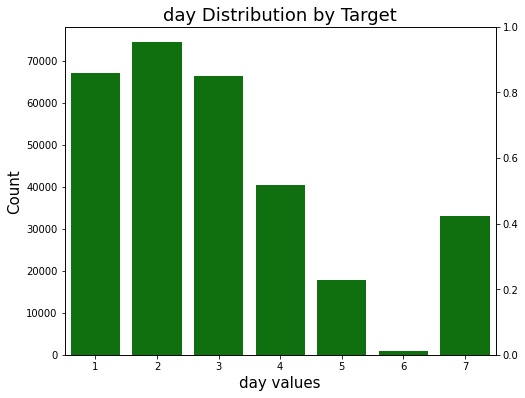

In [32]:
data_cols = ['day', 'month']

# Calling the plot function with data columns
ploting_cat_fet(df_train, data_cols, vis_row = 5, vis_col = 2)

Curiously, the data have two values that have few entries.

- In the day column, the value 6 (maybe saturday?) have less entries.

- In the month column, the value 6 (maybe the holidays?) have less entries.

At this moment, I will not transform it in dummy features, but could be a good solution to test.

## Encoding Data Features

In [33]:
# Transfer the cyclical features into two dimensional sin-cos features
# https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

df_train = date_cyc_enc(df_train, 'day', 7)
df_test = date_cyc_enc(df_test, 'day', 7)

df_train = date_cyc_enc(df_train, 'month', 12)
df_test = date_cyc_enc(df_test, 'month', 12)

# NOTE, I discovered it on: kaggle.com/gogo827jz/catboost-baseline-with-feature-importance

## Ordinal Feature - High Cardinality Features

- I will start by the ord_5 feature

- It's an sparse ordinal feature

In [34]:
#Credit of this features to: 
# https://www.kaggle.com/gogo827jz/catboost-baseline-with-feature-importance

import string

# Then encode 'ord_5' using ACSII values

# Option 1 : Add up the indices of two letters in string.ascii_letters
df_train['ord_5_oe_add'] = df_train['ord_5'].apply(lambda x : sum([(string.ascii_letters.find(letter) + 1) for letter in x]))
df_test['ord_5_oe_add'] = df_test['ord_5'].apply(lambda x : sum([(string.ascii_letters.find(letter) + 1) for letter in x]))

# Option 2 : Join the indices of two letters in string.ascii_letters
df_train['ord_5_oe_join'] = df_train['ord_5'].apply(lambda x : float(''.join(str(string.ascii_letters.find(letter) + 1) for letter in x)))
df_test['ord_5_oe_join'] = df_test['ord_5'].apply(lambda x : float(''.join(str(string.ascii_letters.find(letter) + 1) for letter in x)))

# Option 3 : Split 'ord_5' into two new columns using the indices of two letters in string.ascii_letters, separately
df_train['ord_5_oe1'] = df_train['ord_5'].apply(lambda x : (string.ascii_letters.find(x[0]) + 1))
df_test['ord_5_oe1'] = df_test['ord_5'].apply(lambda x : (string.ascii_letters.find(x[0]) + 1))

df_train['ord_5_oe2'] = df_train['ord_5'].apply(lambda x : (string.ascii_letters.find(x[1]) + 1))
df_test['ord_5_oe2'] = df_test['ord_5'].apply(lambda x : (string.ascii_letters.find(x[1]) + 1))

for col in ['ord_5_oe1', 'ord_5_oe2', 'ord_5_oe_add', 'ord_5_oe_join']:
    df_train[col] = df_train[col].astype('float64')
    df_test[col] = df_test[col].astype('float64')

In [35]:
df_train[['ord_5', 'ord_5_oe_add', 'ord_5_oe_join', 'ord_5_oe1', 'ord_5_oe2']].head()

,ord_5,ord_5_oe_add,ord_5_oe_join,ord_5_oe1,ord_5_oe2
0,kr,29.0,1118.0,11.0,18.0
1,bF,34.0,232.0,2.0,32.0
2,Jc,39.0,363.0,36.0,3.0
3,kW,60.0,1149.0,11.0,49.0
4,qP,59.0,1742.0,17.0,42.0


Cool, now, let's work on nominal features

## Nominal Features - High Cardinality Features

### Feature Hasher

In [36]:
high_card_feats = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

#### Nominal Features before hash transformation

In [37]:
resumetable(df_train[high_card_feats])

Dataset Shape: (300000, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5,7.49
1,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8,8.74
2,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527,9.97
3,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684,10.84
4,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0,13.27


We can see high-cardinality in all this columns. The fewer cardinality is 222 values and the highest is 11981 unique values.

To work with these features, I will try the Hash Trick Solution. Let's see if it give us good results.

### Hash Trick (Feature Hash)

- I got this solution from @Giba

In [38]:
for col in high_card_feats:
    df_train[f'hash_{col}'] = df_train[col].apply(lambda x : hash(str(x)) % 5000)
    df_test[f'hash_{col}'] = df_test[col].apply(lambda x : hash(str(x)) % 5000)

### Encoding with the Frequency

In [39]:
for col in high_card_feats:
    enc_nom_1 = (df_train.groupby(col).size()) / len(df_train)
    df_train[f'freq_{col}'] = df_train[col].apply(lambda x : enc_nom_1[x])
    
    #df_test[f'enc_{col}'] = df_test[col].apply(lambda x : enc_nom_1[x])

### Label Encoder

In [40]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding
for f in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    if df_train[f].dtype == 'object' or df_test[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f'le_{f}'] = lbl.transform(list(df_train[f].values))
        df_test[f'le_{f}'] = lbl.transform(list(df_test[f].values))

Cool!<br>
After all transformations done, we can see the summary of the features and what type differences we got.

In [41]:
new_feat = ['hash_nom_5', 'hash_nom_6', 'hash_nom_7', 'hash_nom_8',
           'hash_nom_9', 'freq_nom_5', 'freq_nom_6', 'freq_nom_7',
           'freq_nom_8', 'freq_nom_9', 'le_nom_5', 'le_nom_6',
           'le_nom_7', 'le_nom_8', 'le_nom_9']

resumetable(df_train[high_card_feats + new_feat])

Dataset Shape: (300000, 20)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5,7.49
1,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8,8.74
2,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527,9.97
3,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684,10.84
4,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0,13.27
5,hash_nom_5,int64,0,210,3887,1016,1080,7.42
6,hash_nom_6,int64,0,501,3119,1939,3066,8.67
7,hash_nom_7,int64,0,1075,2301,2047,4837,9.77
8,hash_nom_8,int64,0,1812,3714,3339,153,10.51
9,hash_nom_9,int64,0,4554,2965,2860,87,11.86


#### Looking nominal features after hash trick transformation

In [42]:
df_train[['nom_5', 'hash_nom_5', 'freq_nom_5', 'le_nom_5']].head()

,nom_5,hash_nom_5,freq_nom_5,le_nom_5
0,50f116bcf,3887,0.008647,78
1,b3b4d25d0,1016,0.002640,159
2,3263bdce5,1080,0.008413,44
3,f12246592,2554,0.003250,209
4,5b0f5acd5,1248,0.006700,90


Cool! Now, we can run our model. Let's do it.

## Pre Processing

- I will keep only the frequency encoding to evaluate the results.

Feel free to change if you would.

In [43]:
df_train.drop(['ord_5_ot', 'ord_5', 'hash_nom_6', 'hash_nom_7', 'hash_nom_8', 'hash_nom_9',
              'freq_nom_5', 'freq_nom_6', 'freq_nom_7', 'freq_nom_8', 'freq_nom_9',
              'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis = 1, inplace = True)
df_test.drop(['ord_5', 'hash_nom_6', 'hash_nom_7', 'hash_nom_8', 'hash_nom_9',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis = 1, inplace = True)

#### Setting X and Y

In [44]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 30.95 Mb (57.1% reduction)
Mem. usage decreased to 13.73 Mb (66.7% reduction)


In [45]:
X_train = df_train.drop(["id", "target"], axis = 1)
y_train = df_train["target"]
y_train = y_train.astype(bool)
X_test = df_test.drop(["id"], axis = 1)

X_train.shape

(300000, 46)

### Libraries to Machine Learning Modeling

In [46]:
# Importing the auxiliar and preprocessing librarys
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

# Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

## Creating pipeline to evaluate different models

In [47]:
clfs = []
seed = 42

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier", XGBClassifier()))

clfs.append(("DecisionTreeClassifier", DecisionTreeClassifier()))

clfs.append(("RandomForestClassifier", RandomForestClassifier(n_estimators=100)))

clfs.append(("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=100)))

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",ExtraTreesClassifier()))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'roc_auc'
n_folds = 7

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    cv_results = cross_val_score(model, 
                                 X_train.values, y_train, 
                                 cv= kfold, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

LogReg: 0.749999 (+/- 0.002277)
XGBClassifier: 0.771168 (+/- 0.002244)
DecisionTreeClassifier: 0.571017 (+/- 0.002854)
RandomForestClassifier: 0.737393 (+/- 0.003149)
GradientBoostingClassifier: 0.759458 (+/- 0.002174)
RidgeClassifier: 0.749930 (+/- 0.002275)
BaggingClassifier: 0.681886 (+/- 0.002838)
ExtraTreesClassifier: 0.737946 (+/- 0.002229)


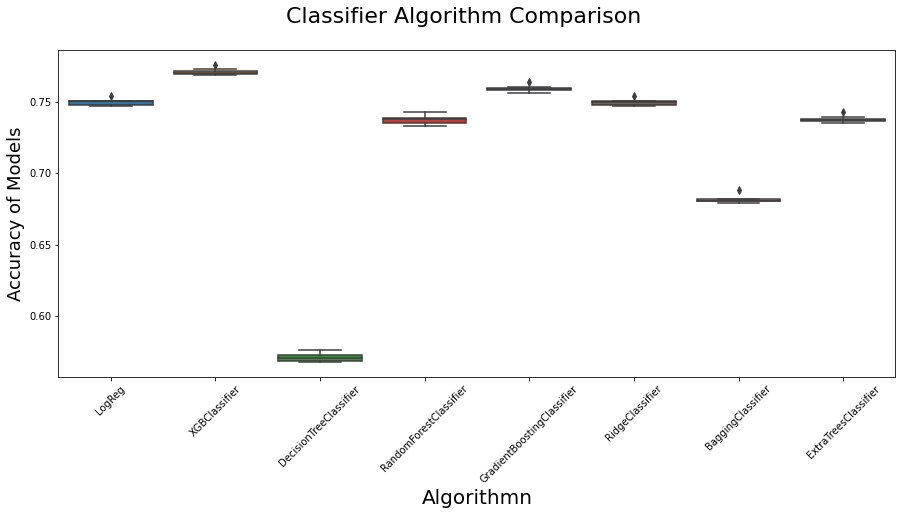

In [48]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
ax = sns.boxplot(data = results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20) 
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()

We can see that Xgb is the best model. Let's use it with hyperopt.

## XGB - HyperOpt Optimization

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time

def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 12
    count=1
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    # tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(submission.shape[0])
    # y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in kf.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=500, random_state=4, 
            verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    
    return -(score_mean / FOLDS)

space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 200, 5))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [.5, 0.6, 0.7, .8]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

### HyperOpt Run

In [50]:
help(fmin)

Help on function fmin in module hyperopt.fmin:

fmin(fn, space, algo=None, max_evals=None, timeout=None, loss_threshold=None, trials=None, rstate=None, allow_trials_fmin=True, pass_expr_memo_ctrl=None, catch_eval_exceptions=False, verbose=True, return_argmin=True, points_to_evaluate=None, max_queue_len=1, show_progressbar=True, early_stop_fn=None, trials_save_file='')
    Minimize a function over a hyperparameter space.
    
    More realistically: *explore* a function over a hyperparameter space
    according to a given algorithm, allowing up to a certain number of
    function evaluations.  As points are explored, they are accumulated in
    `trials`
    
    
    Parameters
    ----------
    
    fn : callable (trial point -> loss)
        This function will be called with a value generated from `space`
        as the first and possibly only argument.  It can return either
        a scalar-valued loss, or a dictionary.  A returned dictionary must
        contain a 'status' key with

In [58]:
best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 30
           )

                                                      
############## New Run ################
params = {'max_depth': 6, 'gamma': '0.568', 'subsample': '0.60', 'reg_alpha': '0.056', 'reg_lambda': '0.134', 'learning_rate': '0.038', 'num_leaves': '80.000', 'colsample_bytree': '0.722', 'min_child_samples': '160.000', 'feature_fraction': '0.677', 'bagging_fraction': '0.663'}
[21:28:32] WARNING: ../src/learner.cc:767:            
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves", "verbose" } are not used.

1 CV - score: 0.7742                                  
[21:28:36] WARNING: ../src/learner.cc:767:            
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves", "verbose" } are not used.

2 CV - score: 0.7731                                  
[21:28:40] WARNING: ../src/learner.cc:767:            
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves", "verbose" } are not used.

3 C

KeyboardInterrupt: 

### Best params

In [57]:
best_params = space_eval(space, best)
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'bagging_fraction': 0.4667779687880642,
 'colsample_bytree': 0.4487657423034243,
 'feature_fraction': 0.5039912775128653,
 'gamma': 0.09944800122077488,
 'learning_rate': 0.13851094825876353,
 'max_depth': 4,
 'min_child_samples': 140,
 'num_leaves': 45,
 'reg_alpha': 0.03317868170471262,
 'reg_lambda': 0.35933398943324685,
 'subsample': 0.8}

### Predicting with best params Xgb

In [56]:
clf = xgb.XGBClassifier(
    n_estimators = 500,
    **best_params,
    tree_method = 'gpu_hist'
)

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)[:, 1]

[21:27:59] WARNING: ../src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.



Cool! Now, let's see what's the features that have more importance to the classification.

## Weights

In [54]:
feature_important = clf.get_booster().get_score(importance_type = "weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = False)

# Top 10 features
data.head(20)

,score
le_nom_6,750.0
hash_nom_5,678.0
le_nom_5,674.0
le_nom_7,506.0
le_nom_8,434.0
le_nom_9,406.0
ord_5_oe1,310.0
ord_5_oe_join,275.0
ord_3,260.0
ord_4,258.0


## Setting submission CSV

In [55]:
submission['target'] = y_preds
submission.to_csv('XGB_hypopt_model.csv')